In [2]:
!pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 110.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


# Preparar a Data

In [4]:
from river import (
    stream,
    compose,
    preprocessing,
    evaluate,
    metrics,
    tree,
    imblearn,
    stats,
    multiclass,
    linear_model,
    ensemble,
    optim,
    naive_bayes,
    forest,
    multioutput,
    neighbors
)


import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt 
from sklearn.metrics import mean_squared_error

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/weather.csv")

target = "weather"

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the class labels
label_encoder.fit(df[target])

# Transform the class labels into integer values
df[target] = label_encoder.transform(df[target])

# Print the encoded labels

df = df.drop(["date"], axis=1)

y = df[target]
x = df.drop(["weather"], axis=1)




RuntimeError: ignored

ImportError: ignored

In [ ]:
shift_df = df.shift(periods = -1)
shift_df = shift_df.rename(columns={"precipitation": "precipitation_y", "temp_max": "temp_max_y", "temp_min":"temp_min_y", "wind": "wind_y", "weather": "weather_y"})

weather_y = shift_df["weather_y"]

weather_y[1460:1459:-1] = weather_y[1459]

Y = shift_df.drop(["weather_y"], axis=1)

Y.iloc[1460:1459:-1] = Y.iloc[1459]





,precipitation_y,temp_max_y,temp_min_y,wind_y
0,10.9,10.6,2.8,4.5
1,0.8,11.7,7.2,2.3
2,20.3,12.2,5.6,4.7
3,1.3,8.9,2.8,6.1
4,2.5,4.4,2.2,2.2
...,...,...,...,...
1456,1.5,5.0,1.7,1.3
1457,0.0,7.2,0.6,2.6
1458,0.0,5.6,-1.0,3.4
1459,0.0,5.6,-2.1,3.5


# Regressão multivariada

In [ ]:
from river import metrics
c = compose.Select('precipitation', 'temp_max', 'temp_min', 'wind')
scaler = preprocessing.StandardScaler()
m = neighbors.KNNRegressor(
        n_neighbors = 17,
        window_size=1000
    )

model = multioutput.RegressorChain(
    model=(
        scaler | m
    ),
    order=["wind_y", "precipitation_y", "temp_min_y", "temp_max_y"]
)

  
# Initialize the regression metrics
mae = metrics.multioutput.MicroAverage(metrics.MAE())  # Mean Absolute Error
mse = metrics.multioutput.MicroAverage(metrics.MSE())  # Mean Squared Error
rmse = metrics.multioutput.MicroAverage(metrics.RMSE())  # Root Mean Squared Error
r2 = metrics.multioutput.MicroAverage(metrics.R2())  # R-squared

true_max = []
pred_max = []

true_min = []
pred_min = []

true_prep = []
pred_prep= []

true_wind = []
pred_wind = []

pred = []

# Evaluate the regression model
for xi, yi in stream.iter_pandas(df, Y):


    y_pred = model.predict_one(xi)

    pred.append(y_pred)

    true_max.append(yi.get('temp_max_y'))
    pred_max.append(y_pred.get('temp_max_y'))
    
    true_min.append(yi.get('temp_min_y'))
    pred_min.append(y_pred.get('temp_min_y'))
    
    true_prep.append(yi.get('precipitation_y'))
    pred_prep.append(y_pred.get('precipitation_y'))
    
    true_wind.append(yi.get('wind_y'))
    pred_wind.append(y_pred.get('wind_y'))
    #print(f'pred: {y_pred}, true: {yi}')
    model.learn_one(xi, yi)

    #mae.update(yi, y_pred)
    #mse.update(yi, y_pred)
    #rmse.update(yi, y_pred)
    #r2.update(yi, y_pred)


# Obtain the computed metric values
mae_value = mae.get()
mse_value = mse.get()
rmse_value = rmse.get()
r2_value = r2.get()

print("Mean Absolute Error:", mae_value)
print("Mean Squared Error:", mse_value)
print("Root Mean Squared Error:", rmse_value)
print("R-squared:", r2_value)

print("Mean Absolute Error:", mae_value)

pred_max[0] = true_max[0]
pred_min[0] = true_min[0]
pred_prep[0] = true_prep[0]
pred_wind[0] = true_wind[0]

print("Temp Max Mean Squared Error:", mean_squared_error(np.array(true_max), np.array(pred_max)))
print("Temp Min Mean Squared Error:", mean_squared_error(np.array(true_min), np.array(pred_min)))
print("Precipitation Mean Squared Error:", mean_squared_error(np.array(true_prep), np.array(pred_prep)))
print("Wind Mean Squared Error:", mean_squared_error(np.array(true_wind), np.array(pred_wind)))


evaluate.progressive_val_score(stream.iter_pandas(df, Y), model, mae)
evaluate.progressive_val_score(stream.iter_pandas(df, Y), model, mse)
evaluate.progressive_val_score(stream.iter_pandas(df, Y), model, rmse)
evaluate.progressive_val_score(stream.iter_pandas(df, Y), model, r2)

Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0
R-squared: 0.0
Mean Absolute Error: 0.0
Temp Max Mean Squared Error: 21.259273052424906
Temp Min Mean Squared Error: 10.439156262737457
Precipitation Mean Squared Error: 44.38395301716738
Wind Mean Squared Error: 2.1110477608099343


MicroAverage(MAE): 2.75731

In [ ]:
print(evaluate.progressive_val_score(stream.iter_pandas(df, Y), model, mae))
print(evaluate.progressive_val_score(stream.iter_pandas(df, Y), model, mse))
print(evaluate.progressive_val_score(stream.iter_pandas(df, Y), model, rmse))
print(evaluate.progressive_val_score(stream.iter_pandas(df, Y), model, r2))

MicroAverage(MAE): 2.744524
MicroAverage(MSE): 19.408315
MicroAverage(RMSE): 4.400304
MicroAverage(R2): 0.683039


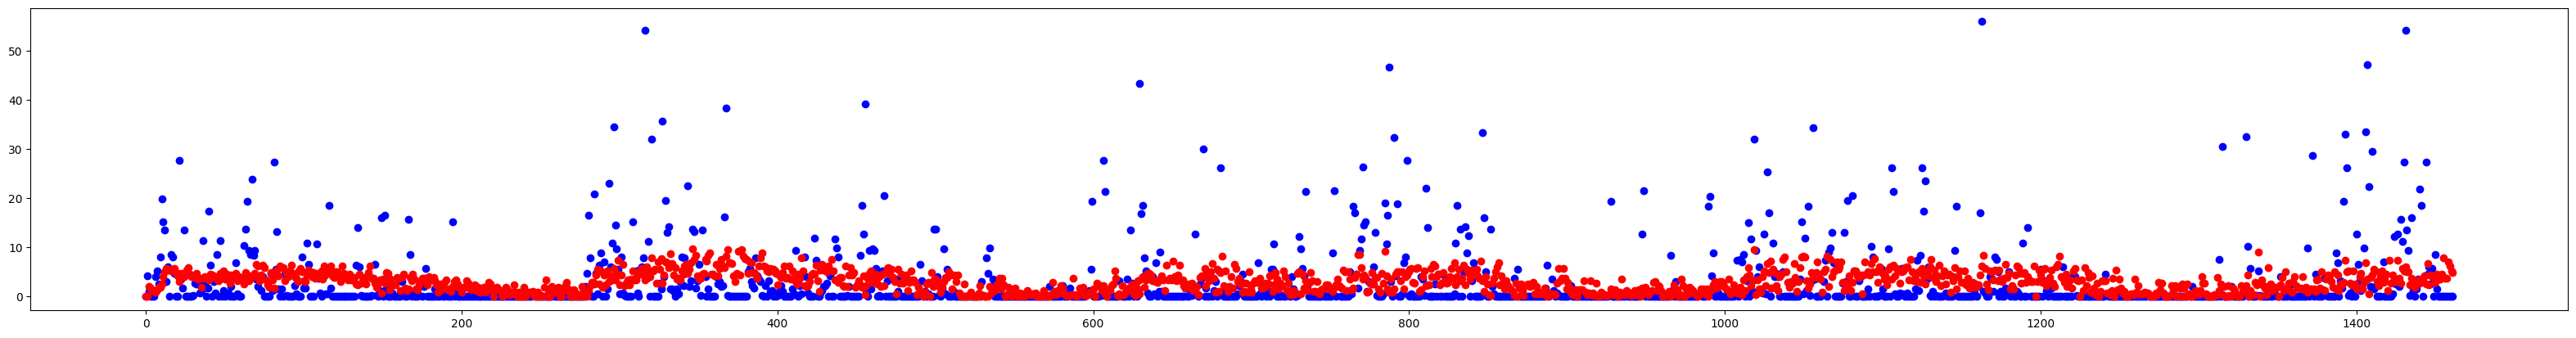

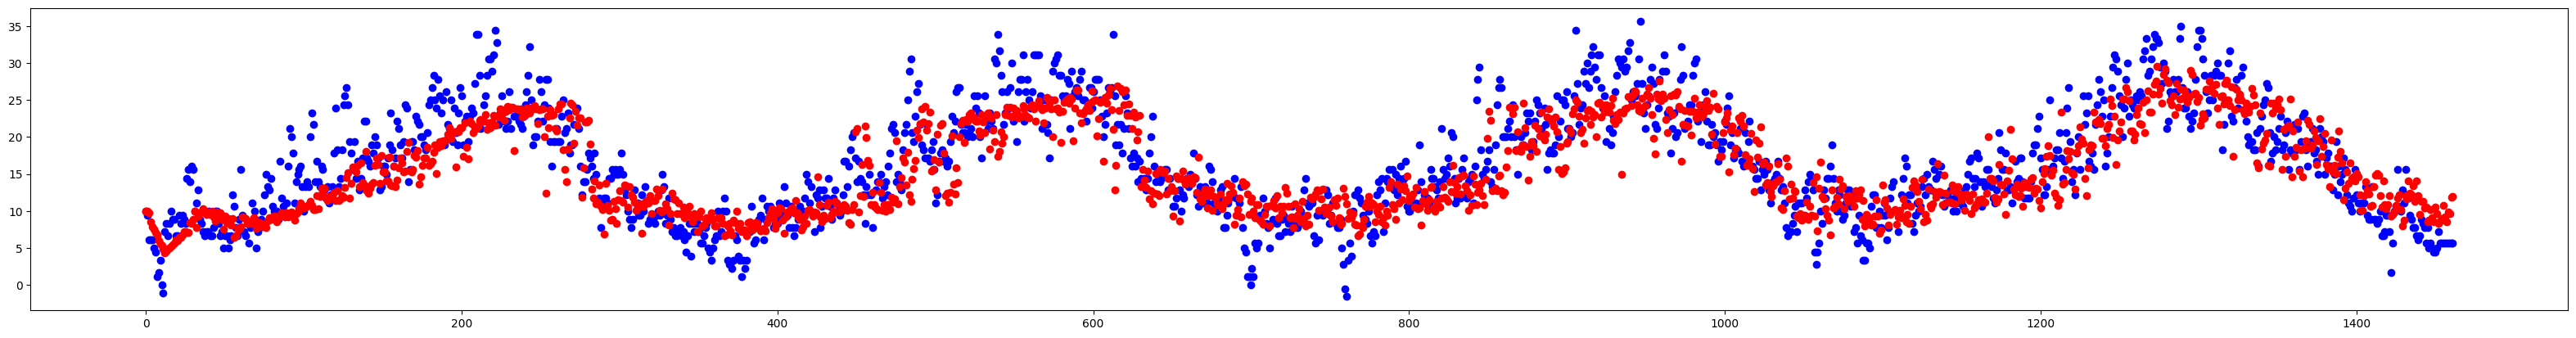

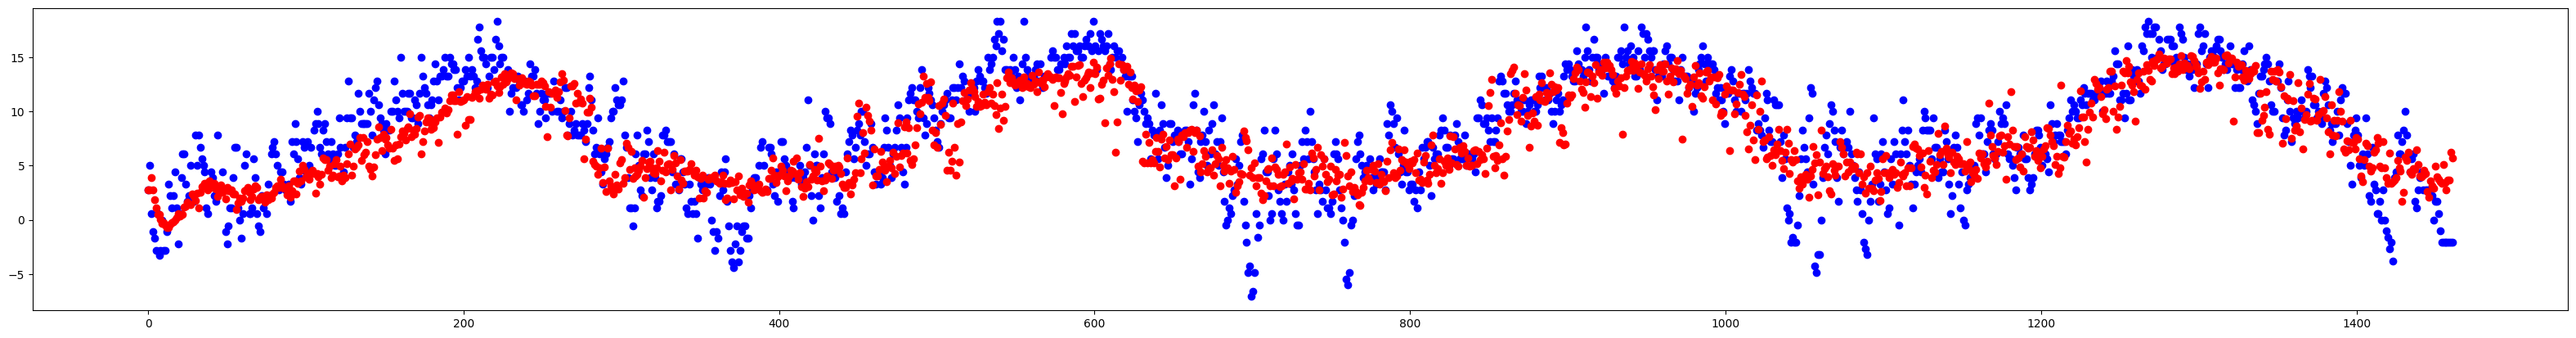

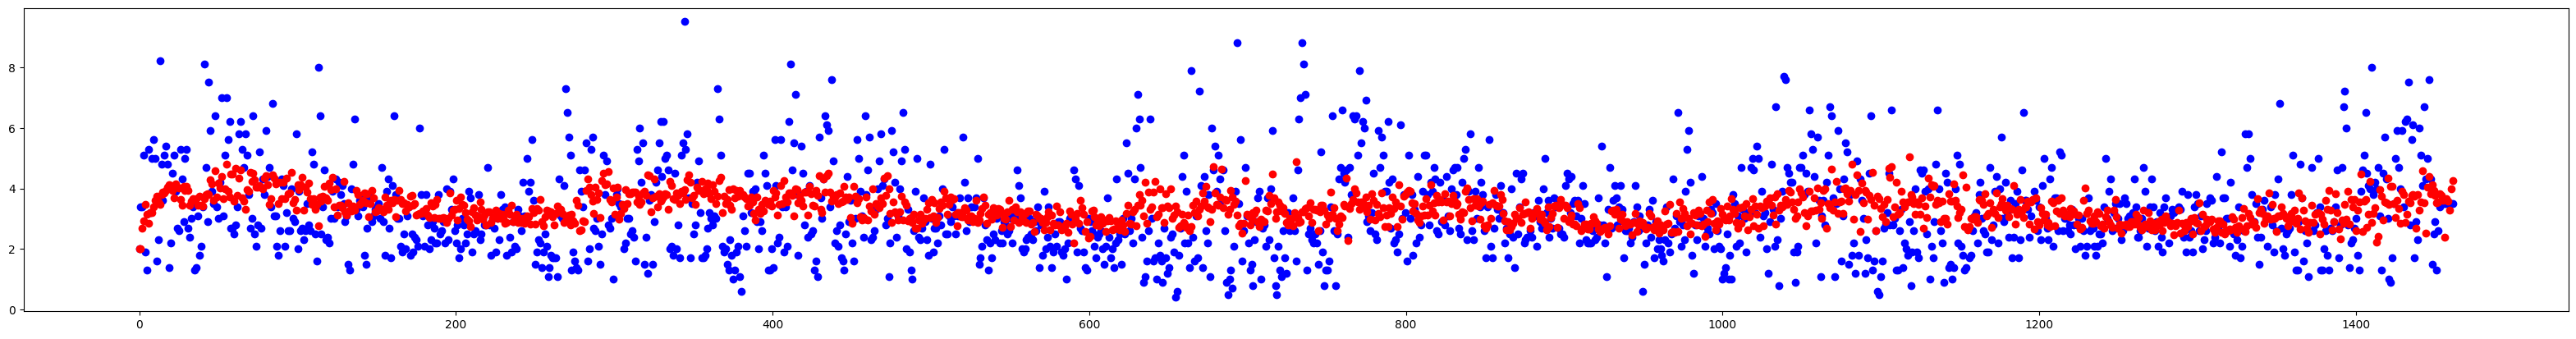

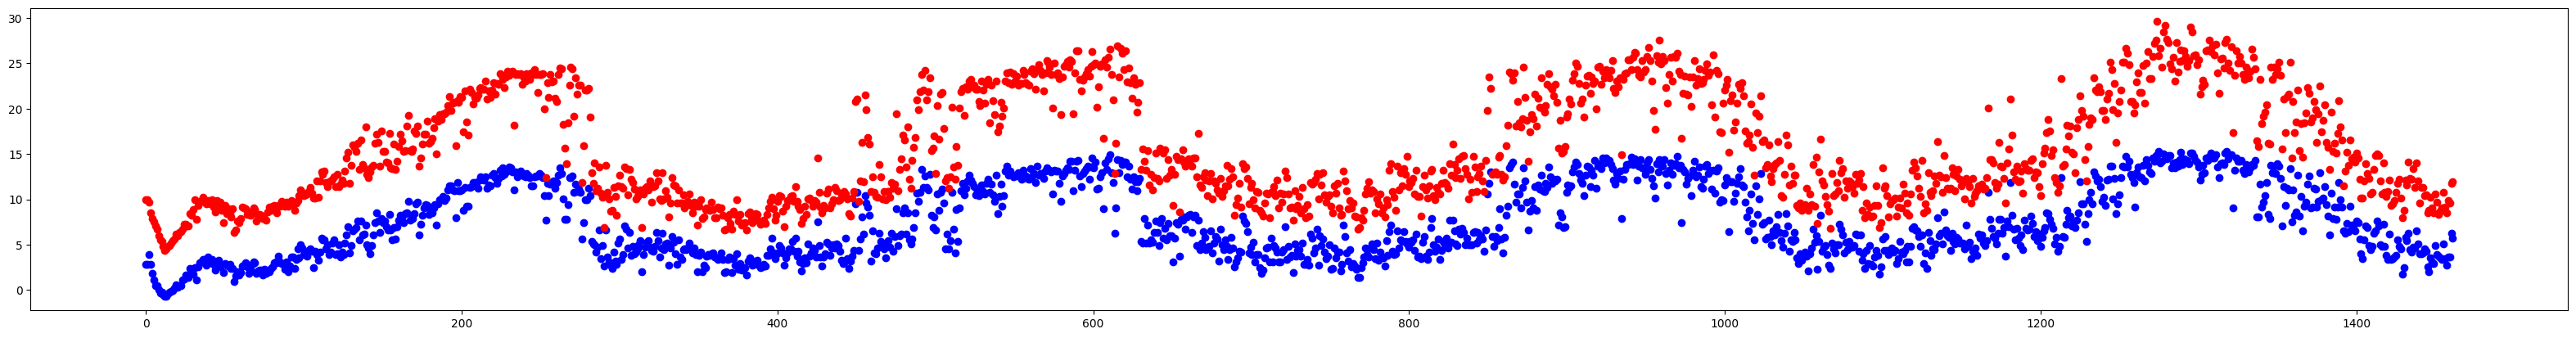

In [ ]:
x = np.linspace(0,1461, 1461)

plt.figure().set_figwidth(40)

plt.plot(x,true_prep, "ob")
plt.plot(x,pred_prep, "or")

plt.show() 

plt.figure().set_figwidth(40)

plt.plot(x,true_max, "ob")
plt.plot(x,pred_max, "or")

plt.show() 

plt.figure().set_figwidth(40)

plt.plot(x,true_min, "ob")
plt.plot(x,pred_min, "or")

plt.show() 

plt.figure().set_figwidth(40)

plt.plot(x,true_wind, "ob")
plt.plot(x,pred_wind, "or")

plt.show() 

plt.figure().set_figwidth(40)

plt.plot(x,pred_min, "ob")
plt.plot(x,pred_max, "or")

plt.show() 

# Classificação

In [ ]:
model = imblearn.RandomUnderSampler(
    (
        preprocessing.StandardScaler() |
        forest.ARFClassifier(seed=7, leaf_prediction="nb")
    ),
    desired_dist={0 : 0.04, 1: 0.07, 2:0.43, 3:0.02, 4:0.44 },
    seed=42
)


metric = metrics.ClassificationReport()

for xi, yi in stream.iter_pandas(df, weather_y):
  y_pred = model.predict_proba_one(xi)
  #print(f'pred: {y_pred}, true: {yi}')
  model.learn_one(xi, yi)


evaluate.progressive_val_score(stream.iter_pandas(df, weather_y), model, metric)

           Precision   Recall   F1       Support  
                                                  
     0.0       0.00%    0.00%    0.00%        52  
     1.0      46.67%    6.93%   12.07%       101  
     2.0      66.07%   68.95%   67.48%       641  
     3.0      66.67%   15.38%   25.00%        26  
     4.0      65.06%   78.16%   71.01%       641  
                                                  
   Macro      48.89%   33.89%   35.11%            
   Micro      65.30%   65.30%   65.30%            
Weighted      61.95%   65.30%   62.04%            

                 65.30% accuracy                  

In [ ]:
scaler = preprocessing.StandardScaler()
m = forest.ARFClassifier(seed=43, leaf_prediction="nb")
model = scaler | m

y_true = []
y_pred = []

metric = metrics.ClassificationReport()

for xi, yi in stream.iter_pandas(df, weather_y):
  y_pred = model.predict_proba_one(xi)
  model.learn_one(xi, yi)


evaluate.progressive_val_score(stream.iter_pandas(df, weather_y), model, metric)



           Precision   Recall   F1       Support  
                                                  
     0.0      50.00%   11.54%   18.75%        52  
     1.0      58.33%    6.93%   12.39%       101  
     2.0      64.61%   71.76%   68.00%       641  
     3.0      66.67%   23.08%   34.29%        26  
     4.0      66.20%   73.95%   69.86%       641  
                                                  
   Macro      61.16%   37.45%   40.66%            
   Micro      65.23%   65.23%   65.23%            
Weighted      64.39%   65.23%   62.62%            

                 65.23% accuracy                  

In [ ]:


model = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |
        forest.ARFClassifier(seed=8, leaf_prediction="nb")
    ),
    n_models=7,
    seed=42
)

y_true = []
y_pred = []

metric = metrics.ClassificationReport()

for xi, yi in stream.iter_pandas(df, weather_y):
  y_pred = model.predict_proba_one(xi)
  model.learn_one(xi, yi)


evaluate.progressive_val_score(stream.iter_pandas(df, weather_y), model, metric)

           Precision   Recall   F1       Support  
                                                  
     0.0      66.67%    7.69%   13.79%        52  
     1.0      40.00%    1.98%    3.77%       101  
     2.0      65.19%   71.29%   68.11%       641  
     3.0      66.67%   15.38%   25.00%        26  
     4.0      65.95%   76.44%   70.81%       641  
                                                  
   Macro      60.89%   34.56%   36.30%            
   Micro      65.50%   65.50%   65.50%            
Weighted      63.86%   65.50%   62.15%            

                 65.50% accuracy                  

In [ ]:
model = ensemble.ADWINBoostingClassifier(
    model=(
        preprocessing.StandardScaler() |
        forest.ARFClassifier(seed=8, leaf_prediction="nba")
    ),
    n_models=7,
    seed=42
)

y_true = []
y_pred = []

metric = metrics.ClassificationReport()

for xi, yi in stream.iter_pandas(df, weather_y):
  y_pred = model.predict_proba_one(xi)
  model.learn_one(xi, yi)


evaluate.progressive_val_score(stream.iter_pandas(df, weather_y), model, metric)

           Precision   Recall   F1       Support  
                                                  
     0.0      66.67%    3.85%    7.27%        52  
     1.0       0.00%    0.00%    0.00%       101  
     2.0      64.99%   74.41%   69.38%       641  
     3.0      66.67%    7.69%   13.79%        26  
     4.0      67.13%   75.51%   71.07%       641  
                                                  
   Macro      53.09%   32.29%   32.30%            
   Micro      66.05%   66.05%   66.05%            
Weighted      61.52%   66.05%   62.13%            

                 66.05% accuracy                  

In [ ]:
model = ensemble.AdaBoostClassifier(
    model=(
        preprocessing.StandardScaler() |
        naive_bayes.GaussianNB()
    ),
    n_models=7,
    seed=42
)

y_true = []
y_pred = []

metric = metrics.ClassificationReport()

for xi, yi in stream.iter_pandas(df, weather_y):
  y_pred = model.predict_proba_one(xi)
  model.learn_one(xi, yi)


evaluate.progressive_val_score(stream.iter_pandas(df, weather_y), model, metric)


           Precision   Recall   F1       Support  
                                                  
     0.0      16.83%   32.69%   22.22%        52  
     1.0      50.00%    1.98%    3.81%       101  
     2.0      67.45%   58.50%   62.66%       641  
     3.0      21.95%   34.62%   26.87%        26  
     4.0      63.90%   75.66%   69.29%       641  
                                                  
   Macro      44.03%   40.69%   36.97%            
   Micro      60.78%   60.78%   60.78%            
Weighted      62.07%   60.78%   59.42%            

                 60.78% accuracy                  

In [ ]:
model = imblearn.RandomSampler(
    (
        preprocessing.StandardScaler() |
        forest.ARFClassifier(seed=8, leaf_prediction="nb")
    ),
    desired_dist={0 : 0.04, 1: 0.07, 2:0.43, 3:0.02, 4:0.44 },
    seed=42
)

y_true = []
y_pred = []

metric = metrics.ClassificationReport()

for xi, yi in stream.iter_pandas(df, weather_y):
  y_pred = model.predict_proba_one(xi)
  model.learn_one(xi, yi)


evaluate.progressive_val_score(stream.iter_pandas(df, weather_y), model, metric)

           Precision   Recall   F1       Support  
                                                  
     0.0      45.45%    9.62%   15.87%        52  
     1.0      30.00%   11.88%   17.02%       101  
     2.0      66.26%   68.33%   67.28%       641  
     3.0       0.00%    0.00%    0.00%        26  
     4.0      65.19%   75.98%   70.17%       641  
                                                  
   Macro      41.38%   33.16%   34.07%            
   Micro      64.48%   64.48%   64.48%            
Weighted      61.37%   64.48%   62.05%            

                 64.48% accuracy                  